In [8]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np

In [9]:
tf.enable_eager_execution()

In [10]:
%matplotlib inline

In [11]:
np.set_printoptions(suppress=True)

# Introduction

<p>Following Marin, Pudlo, & Etroup (2019), we will construct a toy model selection example consisting of three unidimensional models with tractable marginal likelihoods.</p>

1. Model 1 is an exponential distribution with rate parameter  $\lambda$
2. Model 2 is a log-normal distribution with location parameter $\mu$ and fixed scale parameter $\sigma = 1$
3. Model 3 is a gamma distribution with parameters $\alpha = 2$ (shape) and $\beta$ (rate)



# Model definitions

In [ ]:
class ResidualDense(tf.keras.Model):
    """Implements a residual dense layer, aka. y = f(x) + x"""
    
    def __init__(self, units, n_dense=2, activation='elu'):
        """Creates a residual dense layer."""
        super(ResidualDense, self).__init__()
        
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation=activation)
            for _ in range(n_dense)
        ] + [
            tf.keras.layers.Dense(units, activation='linear')
        ])
        
    def call(self, x):
        """Transforms the x via the indentity mapping ELU(f(x) + x)"""
        
        f_x = self.dense(x)
        f_xx = f_x + x
        return tf.nn.elu(f_xx)

class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(InvariantModule, self).__init__()
        
        # Vanilla fully connected
        if meta['dense_type'] == 'fc':
            self.module = tf.keras.Sequential([
                tf.keras.layers.Dense(**meta['dense_args'])
                for _ in range(meta['n_dense_inv'])
            ])
            
            self.post_pooling_dense = tf.keras.Sequential([
                tf.keras.layers.Dense(**meta['dense_args'])
                for _ in range(meta['n_dense_inv'])
            ])
        # Residual
        elif meta['dense_type'] == 'residual':
            
            self.module = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(**meta['dense_args'])
            ]  +  
            [
                ResidualDense(**meta['res_args'])
                for _ in range(meta['n_dense_inv'])
            ])
            
            self.post_pooling_dense = tf.keras.Sequential([
                ResidualDense(**meta['res_args'])
                for _ in range(meta['n_dense_inv'])
            ])
            
        else:
            raise NotImplementedError('Network type must be either dense of residual')

    
        
    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.module(x)
        x = tf.reduce_mean(x, axis=1)
        out = self.post_pooling_dense(x)
        return out
    

class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(EquivariantModule, self).__init__()
        
        # Vanilla fully connected
        if meta['dense_type'] == 'fc':
            self.module = tf.keras.Sequential([
                tf.keras.layers.Dense(**meta['dense_args'])
                for _ in range(meta['n_dense_equiv'])
            ])
        # Residual
        elif meta['dense_type'] == 'residual':
            self.module = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(**meta['dense_args'])
            ] +
            [
                ResidualDense(**meta['res_args'])
                for _ in range(meta['n_dense_equiv'])
            ])
            
        else:
            raise NotImplementedError('Network type must be either dense of residual')
        
        self.invariant_module = InvariantModule(meta)
        
    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out
    

class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a 
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, meta):
        """
        Creates a permutationally invariant network 
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        n_equiv : int -- the number of equivariant modules 
        """
        
        super(InvariantNetwork, self).__init__()
        
        self.equiv = tf.keras.Sequential([
            EquivariantModule(meta)
            for _ in range(meta['n_equiv'])
        ])
        self.inv = InvariantModule(meta)
        
    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant 
        representation by first passing it through multiple equivariant 
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out

    
class ModelSelector(tf.keras.Model):
    
    def __init__(self, meta, n_models=3):
        super(ModelSelector, self).__init__()
        
        self.inv_net = InvariantNetwork(inv_h_dim, n_dense_inv, n_equiv)
        self.selector = tf.keras.layers.Dense(n_models, activation='relu')
        self.M = n_models
        
    def call(self, x):
        """
        Computes evidences for model selection.
        """
        
        x = self.inv_net(x)
        evidence = self.selector(x)
        alpha = evidence + 1
        S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
        uncertainty = self.M / S_alpha
        probs = alpha / S_alpha
        return alpha, probs, uncertainty

# Utility functions

In [8]:
def plot_dirichlet_samples(model, data_gen, m_samples, labels, n_val=36, figsize=(15, 9)):
    """Plots model probabilities."""
    
    X_test, m_test = data_gen(n_val)
    alpha, uncertainty, probs = model(X_test)
    m_test = tf.math.argmax(m_test, axis=1).numpy()
    alpha = alpha.numpy()
    probs = probs.numpy()

    f, axarr = plt.subplots(int(np.sqrt(n_val)), int(np.sqrt(n_val)), figsize=figsize)

    for i, ax in enumerate(axarr.flat):
        
        # Sample model probabilities
        s = np.random.dirichlet(alpha[i], m_samples)
        
        # Plot model probabilites
        for k in range(model.K):
            
            # Plot dirichlet samples
            sns.distplot(s[:, k], ax=ax, label=labels[k])
        
        if i == 0:
            ax.legend(fontsize=7)
            
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title('True: {}'.format(labels[m_test[i]]))

    f.tight_layout()

## Losses

In [233]:
def marginal_lik_expon(x_samples):
    """
    Computes the marginal likelihood for an exponential distribution as
    p(x|m) = gamma(n + 1) * (1 + sum(x_samples))^(-n-1)
    """
    
    n = x_samples.shape[1]
    g = gamma_fun(n + 1)
    sum1p = 1 + np.sum(x_samples, axis=(1, 2))
    liks = g * (sum1p ** (-n - 1))
    return liks


def marginal_lik_lognorm(x_samples):
    """
    Computes the marginal likelihood for a lognormal distribution.
    """
    
    n = x_samples.shape[1]
    logsum = np.sum(np.log(x_samples), axis=(1, 2))
    logsum2 = np.sum(np.log(x_samples)**2, axis=(1, 2))
    term1 = (logsum**2) / (2*n*(n+1))
    term2 = (logsum2**2) / 2
    term3 = (logsum**2) / (2*n)
    exp_term = np.exp(-term1 - term2 + term3 - logsum)
    liks = exp_term * ((2*np.pi) ** (-n / 2)) * ((n+1)**(-0.5))
    return liks

def marginal_lik_gamma(x_samples):
    """
    Computes the marignal likelihood for a gamma distribution.
    """
    
    n = x_samples.shape[1]
    expsum = np.exp(np.sum(np.log(x_samples), axis=(1, 2)))
    g = gamma_fun(2*n+1) / (gamma_fun(2)**n)
    powersum1p = (1 + np.sum(x_samples, axis=(1, 2))) ** (-2*n - 1)
    liks = expsum * g * powersum1p
    return liks

In [13]:
def marginal_lik_poisson(x):
    """Computes the marginal likelihood under a poisson distro."""
    
    n = x.shape[1]
    s = np.sum(x, axis=1)
    t = np.sum(np.log(spec.factorial(x)), axis=1)
    liks = spec.factorial(s) / (np.exp(t) * (n+1)**(s+1))
    return liks


def marginal_lik_geom(x):
    """Computes the marginal likelihood under a geometric distro."""
    
    n = x.shape[1]
    s = np.sum(x, axis=1)
    num = spec.factorial(n)*spec.factorial(s)
    denom = spec.factorial(n+s+1)
    liks = num / denom
    return liks


def generate_data_geom_poiss(batch_size, n_points, to_tensor=True):
    
    # Make sure a model is nor oversampled
    batch_size_m = batch_size // 2
    batch_sizes = [batch_size_m, batch_size_m]
    rest_m = batch_size % 2
    bi = np.argmax(np.random.rand(2))
    batch_sizes[bi] += rest_m
    
    # Draw from priors
    lam = np.random.exponential(size=batch_sizes[0])
    mu = np.random.uniform(size=batch_sizes[1])

    # Sample models
    poisson_samples = np.random.poisson(lam, size=(n_points, batch_sizes[0])).T
    geom_samples = np.random.geometric(mu, size=(n_points, batch_sizes[1])).T
    
    # Stack data
    X_batch = np.r_[poisson_samples, geom_samples]
    m_batch = np.concatenate((np.zeros(batch_sizes[0]), 
                              np.ones(batch_sizes[1]))).astype(np.int32)
    
    # Shuffle indices
    shuffle_idx = np.random.permutation(batch_size)
    X_batch = X_batch[shuffle_idx][:, :, np.newaxis]
    m_batch = m_batch[shuffle_idx]
    
    # Convert to one-hot
    m_batch_oh = np.zeros((batch_size, 2))
    m_batch_oh[np.arange(batch_size), m_batch] = 1
    
    if to_tensor:
        X_batch = tf.convert_to_tensor(X_batch, dtype=tf.float32)
        m_batch_oh = tf.convert_to_tensor(m_batch_oh, dtype=tf.float32)
    return X_batch, m_batch_oh

## Data generator

In [14]:
def generate_data(batch_size, n_points, to_tensor=True):
    
    
    # Make sure a model is nor oversampled
    batch_size_m = batch_size // 3
    batch_sizes = [batch_size_m, batch_size_m, batch_size_m]
    rest_m = batch_size % 3
    bi = np.argmax(np.random.rand(3))
    batch_sizes[bi] += rest_m
    
    # Draw from priors
    exp_scales = 1. / np.random.exponential(scale=1., size=batch_sizes[0])
    logn_means = np.random.normal(loc=0., scale=1., size=batch_sizes[1])
    gamma_scales = 1. /np.random.exponential(scale=1., size=batch_sizes[2])

    # Sample models
    exp_samples = np.random.exponential(scale=exp_scales, size=(n_points, batch_sizes[0])).T
    logn_samples = np.random.lognormal(mean=logn_means, sigma=1., size=(n_points, batch_sizes[1])).T
    gamma_samples = np.random.gamma(shape=2., scale=gamma_scales, size=(n_points, batch_sizes[2])).T
    
    # Stack data
    X_batch = np.r_[exp_samples, logn_samples, gamma_samples]
    m_batch = np.concatenate((np.zeros(batch_sizes[0]), 
                              np.ones(batch_sizes[1]), 
                              np.ones(batch_sizes[2]) + 1)).astype(np.int32)
    
    # Shuffle indices
    shuffle_idx = np.random.permutation(batch_size)
    X_batch = X_batch[shuffle_idx][:, :, np.newaxis]
    m_batch = m_batch[shuffle_idx]
    
    # Convert to one-hot
    m_batch_oh = np.zeros((batch_size, 3))
    m_batch_oh[np.arange(batch_size), m_batch] = 1
    
    if to_tensor:
        X_batch = tf.convert_to_tensor(X_batch, dtype=tf.float32)
        m_batch_oh = tf.convert_to_tensor(m_batch_oh, dtype=tf.float32)
    return X_batch, m_batch_oh

## Plot distributions

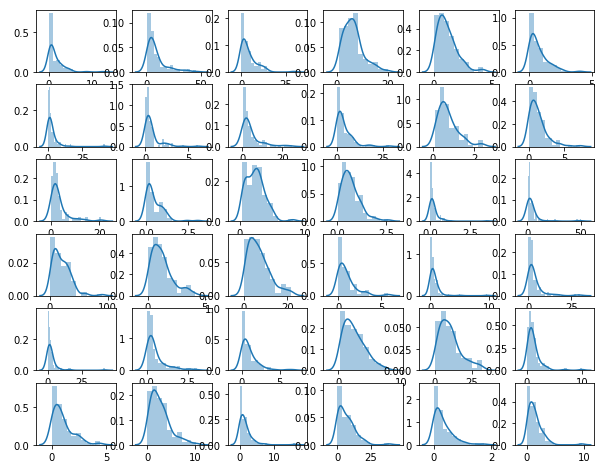

In [103]:
X, _ = generate_data(36, 100, to_tensor=False)

f, axarr = plt.subplots(6, 6, figsize=(10, 8))

for i in range(36):
    sns.distplot(X[i], ax=axarr.flat[i])
f.tight_layout()

# Training parameters

In [377]:
inv_meta = {
    'res_args'       : dict(units=64, n_dense=2, activation='elu'),
    'dense_args'     : dict(units=64, activation='elu'),
    'dense_type'     : 'residual',
    'n_dense_inv'    :  2,
    'n_dense_equiv'  :  3,
    'n_equiv'        :  2
}
n_post_samples = 1000
n_points = 20
n_test = 300
epochs = 20
batch_size = 64
learning_rate = 0.0005
iterations_per_epoch = 500
clip_value = 5.
global_step = tfe.Variable(0, dtype=tf.int32)
annealing_step = tfe.Variable(5000, dtype=tf.int32)
data_gen = partial(generate_data, n_points=n_points)

## Create test

In [378]:
X_test, m_test = data_gen(n_test)

## Create model and optimizer

In [379]:
model = ModelSelector(**nn_params)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Manage checkpoints

In [380]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/edl', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/toy2_edl\ckpt-19


## Run training loop

In [179]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:

        train_loop_online(model, optimizer, data_gen, iterations_per_epoch, batch_size, X_test, m_test, 
                          p_bar, global_step=global_step, annealing_step=annealing_step, clip_value=clip_value)
   
        manager.save()

# Evaluate performance

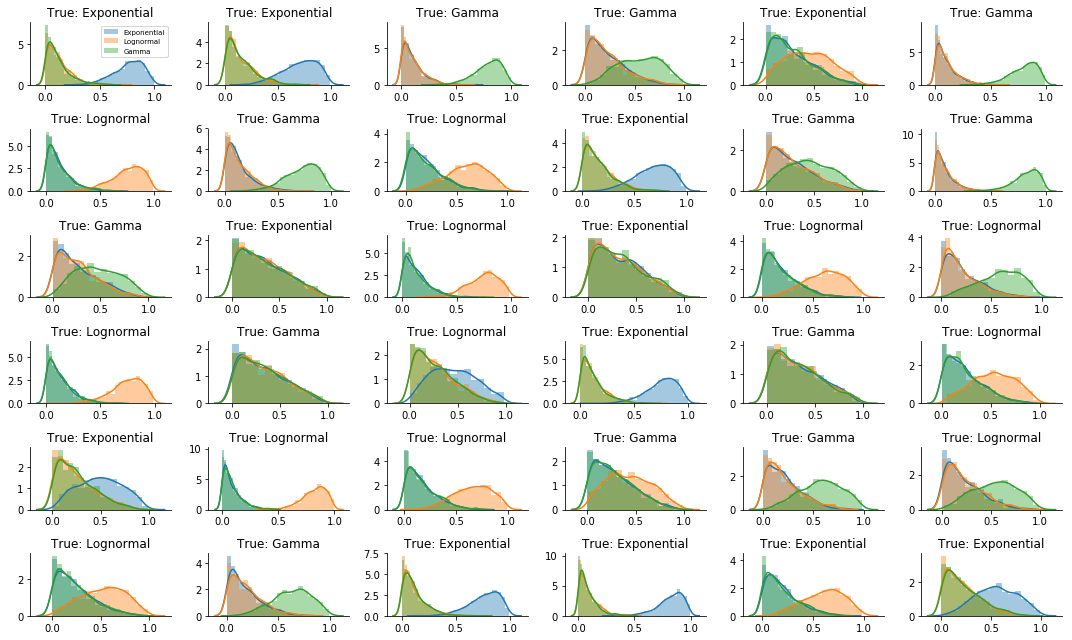

In [260]:
plot_dirichlet_samples(model, data_gen, 1000, ['Exponential', 'Lognormal', 'Gamma'])